# Imports

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()  # Select kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jakobmerten","key":"0cc1e94c311b6c30a0191fe1b98e528b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jaiahuja/skin-cancer-detection
!unzip skin-cancer-detection.zip

Dataset URL: https://www.kaggle.com/datasets/jaiahuja/skin-cancer-detection
License(s): CC0-1.0
 85% 667M/786M [00:00<00:00, 1.38GB/s]
100% 786M/786M [00:00<00:00, 1.38GB/s]
Archive:  skin-cancer-detection.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic 

In [ ]:
# Zuerst stellen wir sicher, dass die notwendigen Pakete installiert sind und importieren diese:
!pip install Augmentor


# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, RandomSampler


# Vision and model imports
import torchvision
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torchvision import models

# Data science imports
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Visualization imports
import matplotlib.pyplot as plt
from tqdm import tqdm

# System imports
import os
import certifi
from collections import Counter

import Augmentor


In [ ]:
# prompt: Spalte 20 % der Daten aus /content/Skin cancer ISIC The International Skin Imaging Collaboration/train proportional aus jedem Unterordner. (Klasse) in den Ordner /content/Skin cancer ISIC The International Skin Imaging Collaboration/val ab zwecks Validierung

import os
import random
import shutil

# Define the base directory and validation directory
base_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
val_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Val'

# Create the validation directory if it doesn't exist
os.makedirs(val_dir, exist_ok=True)

# Iterate through each subfolder (class) in the base directory
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)

    # Ensure it's a directory
    if os.path.isdir(class_dir):
        # Create the corresponding class directory in the validation directory
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Get a list of all files in the class directory
        all_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # Calculate the number of files to move (20%)
        num_files_to_move = int(len(all_files) * 0.20)

        # Randomly select files to move
        files_to_move = random.sample(all_files, num_files_to_move)

        # Move the selected files to the validation directory
        for file_name in files_to_move:
            src_path = os.path.join(class_dir, file_name)
            dest_path = os.path.join(val_dir, class_name, file_name)
            shutil.move(src_path, dest_path)

print("Data split completed. Validation data is in:", val_dir)


Data split completed. Validation data is in: /content/Skin cancer ISIC The International Skin Imaging Collaboration/Val


# Seed

In [ ]:
# Random Seed setzen, damit Ergebnisse reproduzierbar sind


import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(42)

g = torch.Generator()
g.manual_seed(42)


# Augmentierung

In [ ]:
# Zähle alle Labels im ursprünglichen Trainingsdatensatz, bevor augmentiert wird

# Dazu müssen Sie den Original-Trainingsdatensatz verwenden, der NICHT augmentiert wurde
# (oder die Zählung vor der Augmentation durchführen)

# Angenommen, Sie haben bereits die class_counts vom originalen train_dataset
# class_counts = Counter(targets) # von einer früheren Zelle

path_to_training_dataset = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
base_output_dir = "augmented_data"
os.makedirs(base_output_dir, exist_ok=True)

# Zähle die Klassenverteilung im ursprünglichen Trainingsdatensatz
original_train_dataset = torchvision.datasets.ImageFolder(root=path_to_training_dataset, transform=None)
original_targets = original_train_dataset.targets
original_class_counts = Counter(original_targets)
class_names = original_train_dataset.classes

# Bestimme die Größe der größten Klasse
max_class_size = 1000 #max(original_class_counts.values())

print("Zählung der Originalklassen:", original_class_counts)
print("Größe der größten Klasse:", max_class_size)


for i in class_names:
    class_index = original_train_dataset.class_to_idx[i]
    source_dir = os.path.join(path_to_training_dataset, i)
    class_output_dir = os.path.join(base_output_dir, i, "output")
    os.makedirs(class_output_dir, exist_ok=True)

    p = Augmentor.Pipeline(source_dir, output_directory="output")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # Fügen Sie hier Ihre weiteren gewünschten Augmentationen hinzu

    # Berechne, wie viele zusätzliche Samples für diese Klasse benötigt werden
    current_class_size = original_class_counts[class_index]
    samples_to_generate = max(0, max_class_size - current_class_size) # Generiere nur, wenn nötig

    print(f"Klasse '{i}': Originalgröße = {current_class_size}, Zielgröße = {max_class_size}, Samples zu generieren = {samples_to_generate}")

    if samples_to_generate > 0:
        p.sample(samples_to_generate)
    else:
        print(f"Klasse '{i}' ist bereits groß genug, keine Augmentation zur Vergrößerung durchgeführt.")

Zählung der Originalklassen: Counter({0: 370, 1: 370, 2: 370, 3: 370, 4: 370, 5: 370, 6: 370, 7: 370, 8: 370})
Größe der größten Klasse: 1000
Initialised with 92 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.Klasse 'actinic keratosis': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E51D069DA50>: 100%|██████████| 630/630 [00:02<00:00, 225.83 Samples/s]


Initialised with 301 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.Klasse 'basal cell carcinoma': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E52DEEB9E50>: 100%|██████████| 630/630 [00:03<00:00, 209.47 Samples/s]


Initialised with 76 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.Klasse 'dermatofibroma': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E51D24C3C50>: 100%|██████████| 630/630 [00:02<00:00, 221.43 Samples/s]


Initialised with 351 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.Klasse 'melanoma': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E532A34FBD0>: 100%|██████████| 630/630 [00:16<00:00, 38.88 Samples/s]


Initialised with 286 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.Klasse 'nevus': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E51D4FA8890>: 100%|██████████| 630/630 [00:14<00:00, 44.68 Samples/s]


Initialised with 370 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.Klasse 'pigmented benign keratosis': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E51D4FAAED0>: 100%|██████████| 630/630 [00:03<00:00, 204.23 Samples/s]


Initialised with 62 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.Klasse 'seborrheic keratosis': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E51D5CD2F10>: 100%|██████████| 630/630 [00:06<00:00, 91.93 Samples/s] 


Initialised with 145 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.Klasse 'squamous cell carcinoma': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E51D5118850>: 100%|██████████| 630/630 [00:02<00:00, 229.98 Samples/s]


Initialised with 112 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.Klasse 'vascular lesion': Originalgröße = 370, Zielgröße = 1000, Samples zu generieren = 630


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E51D06428D0>: 100%|██████████| 630/630 [00:03<00:00, 196.29 Samples/s]


In [ ]:
# Nun definieren wir Transformatoren für die Daten, laden das Dataset und teilen diese in Trainings- und Validierungsätze auf:

# Definieren Sie Transformationen für das Training und die Validierung
transform = {
    'train': transforms.Compose([
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # zuerst zuschneiden
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.2),
      transforms.RandomRotation(30),
      transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
      transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
    ])
}

# Laden des Datensatzes
train_dataset = torchvision.datasets.ImageFolder(root='Skin cancer ISIC The International Skin Imaging Collaboration/Train1', transform=transform["train"])
val_dataset = torchvision.datasets.ImageFolder(root='Skin cancer ISIC The International Skin Imaging Collaboration/Val1', transform=transform["val"])
test_dataset = torchvision.datasets.ImageFolder(root='Skin cancer ISIC The International Skin Imaging Collaboration/Test1', transform=transform["test"])

In [ ]:
# Zähle alle Labels im Trainingsdatensatz
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
total_samples = sum(class_counts.values())

print("📊 Klassenverteilung im gesamten Trainingsdatensatz (in Prozent):\n")
for cls_idx in sorted(class_counts.keys()):
    count = class_counts[cls_idx]
    percent = (count / total_samples) * 100
    print(f"  Klasse {cls_idx}: {count} Bilder → {percent:.2f}%")

📊 Klassenverteilung im gesamten Trainingsdatensatz (in Prozent):

  Klasse 0: 1000 Bilder → 14.29%
  Klasse 1: 1000 Bilder → 14.29%
  Klasse 2: 1000 Bilder → 14.29%
  Klasse 3: 1000 Bilder → 14.29%
  Klasse 4: 1000 Bilder → 14.29%
  Klasse 5: 1000 Bilder → 14.29%
  Klasse 6: 1000 Bilder → 14.29%


In [ ]:
# Device configuration, Prüfe ob GPU verfügbar ist, falls ja, lasse das Modell auf eie GPU laufen, ansonsten CPU

os.environ['SSL_CERT_FILE'] = certifi.where()
# Konfiguration für Gerät und Speicherverwaltung
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pin_memory_flag = torch.cuda.is_available()

# Infoausgabe zur Umgebung
if pin_memory_flag:
    print("✅ CUDA gefunden – pin_memory aktiviert.")
else:
    print("⚠️  Keine GPU gefunden – pin_memory wird ignoriert. Training läuft auf CPU.")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


✅ CUDA gefunden – pin_memory aktiviert.


# Sampler

In [ ]:
# Balanced Sampling mit WeightedRandomSampler für unbalancierte Klassendatensätze.

# 1. Zähle Bilder pro Klasse
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)

# 2. Berechne Gewicht pro Sample = 1 / (Anzahl in Klasse)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[t] for t in targets]

# 3. Sampler erzeugen
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 4. Trainingsloader neu definieren mit Sampler (nicht shuffle!)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler=sampler, num_workers=2, pin_memory=True)

# 5. Create the Validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=pin_memory_flag)

# 6. Loss ohne Gewichtung
criterion = nn.CrossEntropyLoss()


# Checks der Daten

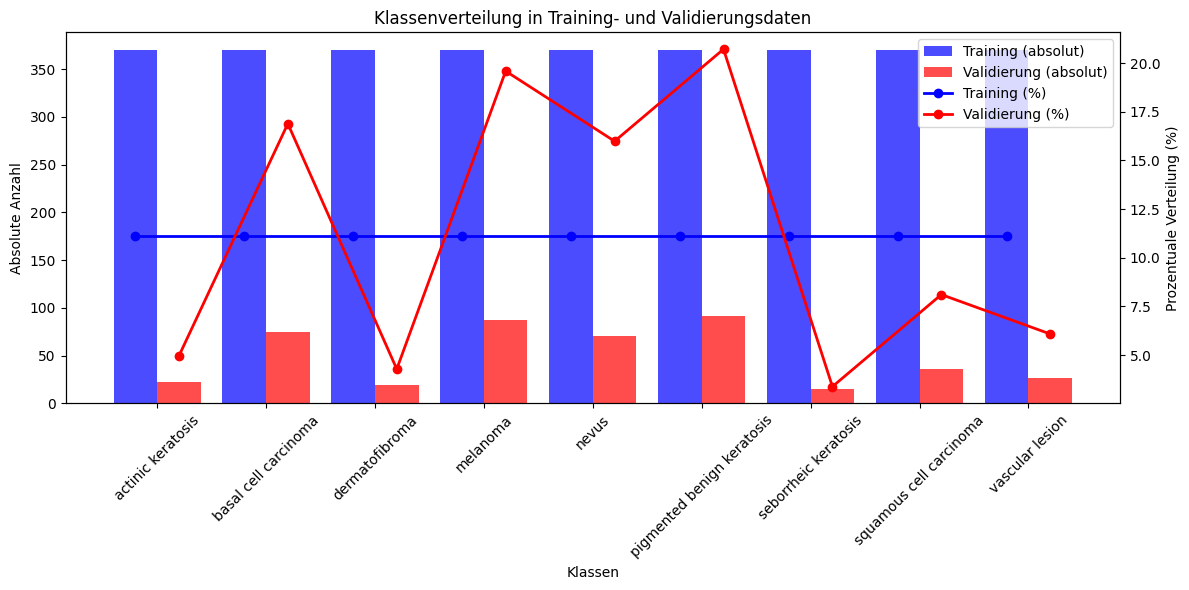


Detaillierte prozentuale Verteilung:

Trainingsdaten:
actinic keratosis: 11.1% (370 Bilder)
basal cell carcinoma: 11.1% (370 Bilder)
dermatofibroma: 11.1% (370 Bilder)
melanoma: 11.1% (370 Bilder)
nevus: 11.1% (370 Bilder)
pigmented benign keratosis: 11.1% (370 Bilder)
seborrheic keratosis: 11.1% (370 Bilder)
squamous cell carcinoma: 11.1% (370 Bilder)
vascular lesion: 11.1% (370 Bilder)

Validierungsdaten:
actinic keratosis: 5.0% (22 Bilder)
basal cell carcinoma: 16.9% (75 Bilder)
dermatofibroma: 4.3% (19 Bilder)
melanoma: 19.6% (87 Bilder)
nevus: 16.0% (71 Bilder)
pigmented benign keratosis: 20.7% (92 Bilder)
seborrheic keratosis: 3.4% (15 Bilder)
squamous cell carcinoma: 8.1% (36 Bilder)
vascular lesion: 6.1% (27 Bilder)


In [ ]:
# Überprüfung der Klassenverteilung


# Überprüfe die Klassenverteilung in den Subsets
from collections import Counter
import matplotlib.pyplot as plt

# Funktion zum Extrahieren der Labels aus einem Subset oder ImageFolder
def get_labels_from_dataset(dataset):
    # If it's a Subset, use the indices to get labels from the original dataset
    if hasattr(dataset, 'indices'):
        return [dataset.dataset.targets[idx] for idx in dataset.indices]
    # If it's an ImageFolder, get labels directly from targets
    elif hasattr(dataset, 'targets'):
        return dataset.targets
    else:
        raise TypeError("Unsupported dataset type")


# Labels für beide Subsets extrahieren
# Use the updated function name
train_labels = get_labels_from_dataset(train_dataset)
val_labels = get_labels_from_dataset(val_dataset)


# Zähle die Häufigkeit der Klassen
train_dist = Counter(train_labels)
val_dist = Counter(val_labels)

# Erstelle einen Graphen mit zwei y-Achsen
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Positionen für die Balken
x = range(len(train_dataset.classes))

# Absolute Zahlen (linke y-Achse)
bars1 = ax1.bar([i-0.2 for i in x], [train_dist[i] for i in range(len(train_dataset.classes))],
                width=0.4, color='blue', alpha=0.7, label='Training (absolut)')
bars2 = ax1.bar([i+0.2 for i in x], [val_dist[i] for i in range(len(train_dataset.classes))],
                width=0.4, color='red', alpha=0.7, label='Validierung (absolut)')

# Prozentuale Verteilung (rechte y-Achse)
total_train = sum(train_dist.values())
total_val = sum(val_dist.values())
line1 = ax2.plot([i-0.2 for i in x], [train_dist[i]/total_train*100 for i in range(len(train_dataset.classes))],
                 'bo-', label='Training (%)', linewidth=2)
line2 = ax2.plot([i+0.2 for i in x], [val_dist[i]/total_val*100 for i in range(len(train_dataset.classes))],
                 'ro-', label='Validierung (%)', linewidth=2)

# Beschriftungen und Layout
ax1.set_xlabel('Klassen')
ax1.set_ylabel('Absolute Anzahl')
ax2.set_ylabel('Prozentuale Verteilung (%)')
plt.title('Klassenverteilung in Training- und Validierungsdaten')
ax1.set_xticks(x)
ax1.set_xticklabels(train_dataset.classes, rotation=45)

# Kombiniere Legenden von beiden y-Achsen
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Gebe die genauen prozentualen Werte aus
print("\nDetaillierte prozentuale Verteilung:")
print("\nTrainingsdaten:")
for i, count in train_dist.items():
    print(f"{train_dataset.classes[i]}: {count/total_train*100:.1f}% ({count} Bilder)")

print("\nValidierungsdaten:")
for i, count in val_dist.items():
    print(f"{train_dataset.classes[i]}: {count/total_val*100:.1f}% ({count} Bilder)")



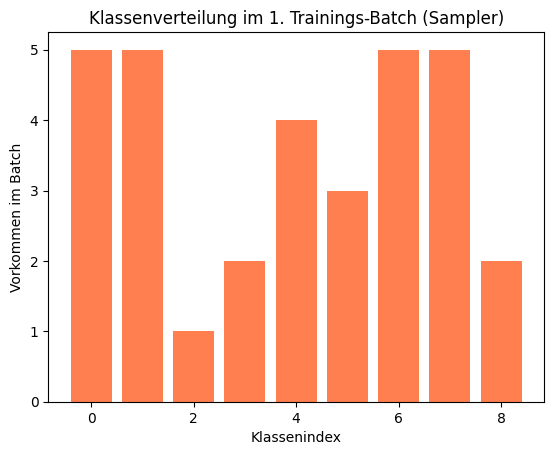

In [ ]:
# Visualisierung der Klassenverteilung im ersten Batch
inputs, labels = next(iter(train_loader))
batch_labels = labels.tolist()

counter = Counter(batch_labels)
plt.bar(counter.keys(), counter.values(), color='coral')
plt.xlabel("Klassenindex")
plt.ylabel("Vorkommen im Batch")
plt.title("Klassenverteilung im 1. Trainings-Batch (Sampler)")
plt.show()



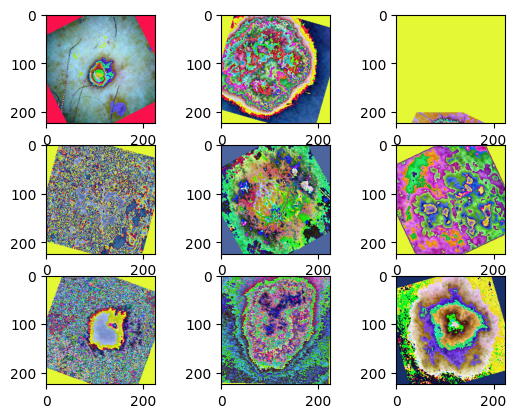

In [ ]:
# Visualisierung der Bilder im ersten Batch
examples = iter(train_loader) # create iterable object
samples, labels = next(examples)  # unpack the batch
# make a plot
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow((samples[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()

# Training

In [ ]:
# Modell laden, Trainieren des Modells und Validierung
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
num_classes = len(train_dataset.classes)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model.to(device)

# Optimierung
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
# --- Learning Rate Schedule initialisieren ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-6, verbose=True)

# Parameter für Early Stopping
best_val_loss = float('inf')  # Initialisiere mit Unendlich
patience = 4  # Anzahl der Epochen, die gewartet wird, bevor das Training beendet wird
early_stop_counter = 0

# Listen zum Speichern von Loss, Accuracy und F1-Score pro Epoche
epoch_train_loss_history = []
epoch_train_acc_history = []
epoch_train_f1_history = []

epoch_val_loss_history = []
epoch_val_acc_history = []
epoch_val_f1_history = []


# Trainingsschleife
num_epochs = 13
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    running_train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    nr_train_samples = 0
    train_labels_global = []
    train_preds_global = []

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics for training
        nr_train_samples += images.shape[0]
        running_train_loss += loss.item() * images.size(0)
        running_train_corrects += torch.sum(preds == labels)
        train_labels_global.extend(labels.tolist())
        train_preds_global.extend(preds.tolist())

        # Update progress bar
        cnt_train_acc = running_train_corrects / nr_train_samples
        cnt_train_loss = running_train_loss / nr_train_samples
        train_f1 = f1_score(train_labels_global, train_preds_global, average='micro')
        train_pbar.set_postfix(loss=f'{cnt_train_loss:.3f}', acc=f'{cnt_train_acc:.3f}', f1=f'{train_f1:.3f}')

    # Store training metrics
    epoch_train_loss_history.append(running_train_loss / nr_train_samples)
    epoch_train_acc_history.append((running_train_corrects / nr_train_samples).cpu().item())
    epoch_train_f1_history.append(train_f1)


    # --- Learning Rate Schedule Step (Epoch-basiert) ---
    # Optional: Aktuelle Lernrate ausgeben, um zu sehen, wie sie sich ändert
    print(f"Epoch {epoch+1} - Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")


    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    running_val_corrects = 0
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')
    nr_val_samples = 0
    val_labels_global = []
    val_preds_global = []

    with torch.no_grad(): # Disable gradient calculation during validation
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update metrics for validation
            nr_val_samples += images.shape[0]
            running_val_loss += loss.item() * images.size(0)
            running_val_corrects += torch.sum(preds == labels)
            val_labels_global.extend(labels.tolist())
            val_preds_global.extend(preds.tolist())

            # Update progress bar
            cnt_val_acc = running_val_corrects / nr_val_samples
            cnt_val_loss = running_val_loss / nr_val_samples
            val_f1 = f1_score(val_labels_global, val_preds_global, average='micro')
            val_pbar.set_postfix(loss=f'{cnt_val_loss:.3f}', acc=f'{cnt_val_acc:.3f}', f1=f'{val_f1:.3f}')

    # Store validation metrics BEFORE calling scheduler.step
    epoch_val_loss_history.append(running_val_loss / nr_val_samples)
    epoch_val_acc_history.append((running_val_corrects / nr_val_samples).cpu().item())
    epoch_val_f1_history.append(val_f1)

    # Now epoch_val_loss_history has at least one element
    scheduler.step(epoch_val_loss_history[-1])

    # --- Early Stopping Check ---
    current_val_loss = epoch_val_loss_history[-1]

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        early_stop_counter = 0  # Setze den Zähler zurück
        # Optional: Speichern Sie hier das beste Modell
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1
        print(f"Early Stopping Counter: {early_stop_counter} von {patience}")

    if early_stop_counter >= patience:
        print(f"Early Stopping nach Epoche {epoch+1} da der Validierungsverlust sich in den letzten {patience} Epochen nicht verbessert hat.")
        break # Beendet die Trainingsschleife


    # Optional: Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {epoch_train_loss_history[-1]:.3f}, Train Acc: {epoch_train_acc_history[-1]:.3f}, Train F1: {epoch_train_f1_history[-1]:.3f} | Val Loss: {epoch_val_loss_history[-1]:.3f}, Val Acc: {epoch_val_acc_history[-1]:.3f}, Val F1: {epoch_val_f1_history[-1]:.3f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/13 [Train]: 100%|██████████| 219/219 [01:00<00:00,  3.62it/s, acc=0.454, f1=0.454, loss=1.463]


Epoch 1 - Learning Rate: 0.000100


Epoch 1/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.80it/s, acc=0.676, f1=0.676, loss=0.977]


Epoch 1 - Train Loss: 1.463, Train Acc: 0.454, Train F1: 0.454 | Val Loss: 0.977, Val Acc: 0.676, Val F1: 0.676


Epoch 2/13 [Train]: 100%|██████████| 219/219 [01:00<00:00,  3.64it/s, acc=0.676, f1=0.676, loss=0.893]


Epoch 2 - Learning Rate: 0.000100


Epoch 2/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.86it/s, acc=0.715, f1=0.715, loss=0.796]


Epoch 2 - Train Loss: 0.893, Train Acc: 0.676, Train F1: 0.676 | Val Loss: 0.796, Val Acc: 0.715, Val F1: 0.715


Epoch 3/13 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.70it/s, acc=0.738, f1=0.738, loss=0.716]


Epoch 3 - Learning Rate: 0.000100


Epoch 3/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.83it/s, acc=0.744, f1=0.744, loss=0.730]


Epoch 3 - Train Loss: 0.716, Train Acc: 0.738, Train F1: 0.738 | Val Loss: 0.730, Val Acc: 0.744, Val F1: 0.744


Epoch 4/13 [Train]: 100%|██████████| 219/219 [00:57<00:00,  3.78it/s, acc=0.778, f1=0.778, loss=0.619]


Epoch 4 - Learning Rate: 0.000100


Epoch 4/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s, acc=0.730, f1=0.730, loss=0.756]


Early Stopping Counter: 1 von 4
Epoch 4 - Train Loss: 0.619, Train Acc: 0.778, Train F1: 0.778 | Val Loss: 0.756, Val Acc: 0.730, Val F1: 0.730


Epoch 5/13 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.74it/s, acc=0.817, f1=0.817, loss=0.515]


Epoch 5 - Learning Rate: 0.000050


Epoch 5/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.85it/s, acc=0.757, f1=0.757, loss=0.711]


Epoch 5 - Train Loss: 0.515, Train Acc: 0.817, Train F1: 0.817 | Val Loss: 0.711, Val Acc: 0.757, Val F1: 0.757


Epoch 6/13 [Train]: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s, acc=0.833, f1=0.833, loss=0.471]


Epoch 6 - Learning Rate: 0.000050


Epoch 6/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.85it/s, acc=0.774, f1=0.774, loss=0.687]


Epoch 6 - Train Loss: 0.471, Train Acc: 0.833, Train F1: 0.833 | Val Loss: 0.687, Val Acc: 0.774, Val F1: 0.774


Epoch 7/13 [Train]: 100%|██████████| 219/219 [01:01<00:00,  3.58it/s, acc=0.839, f1=0.839, loss=0.452]


Epoch 7 - Learning Rate: 0.000050


Epoch 7/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.85it/s, acc=0.767, f1=0.767, loss=0.783]


Early Stopping Counter: 1 von 4
Epoch 7 - Train Loss: 0.452, Train Acc: 0.839, Train F1: 0.839 | Val Loss: 0.783, Val Acc: 0.767, Val F1: 0.767


Epoch 8/13 [Train]: 100%|██████████| 219/219 [01:00<00:00,  3.60it/s, acc=0.854, f1=0.854, loss=0.411]


Epoch 8 - Learning Rate: 0.000025


Epoch 8/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.83it/s, acc=0.774, f1=0.774, loss=0.709]


Early Stopping Counter: 2 von 4
Epoch 8 - Train Loss: 0.411, Train Acc: 0.854, Train F1: 0.854 | Val Loss: 0.709, Val Acc: 0.774, Val F1: 0.774


Epoch 9/13 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.71it/s, acc=0.870, f1=0.870, loss=0.375]


Epoch 9 - Learning Rate: 0.000025


Epoch 9/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.85it/s, acc=0.796, f1=0.796, loss=0.694]


Early Stopping Counter: 3 von 4
Epoch 9 - Train Loss: 0.375, Train Acc: 0.870, Train F1: 0.870 | Val Loss: 0.694, Val Acc: 0.796, Val F1: 0.796


Epoch 10/13 [Train]: 100%|██████████| 219/219 [00:59<00:00,  3.71it/s, acc=0.867, f1=0.867, loss=0.377]


Epoch 10 - Learning Rate: 0.000025


Epoch 10/13 [Valid]: 100%|██████████| 13/13 [00:03<00:00,  3.86it/s, acc=0.791, f1=0.791, loss=0.724]

Early Stopping Counter: 4 von 4
Early Stopping nach Epoche 10 da der Validierungsverlust sich in den letzten 4 Epochen nicht verbessert hat.


# Auswertung

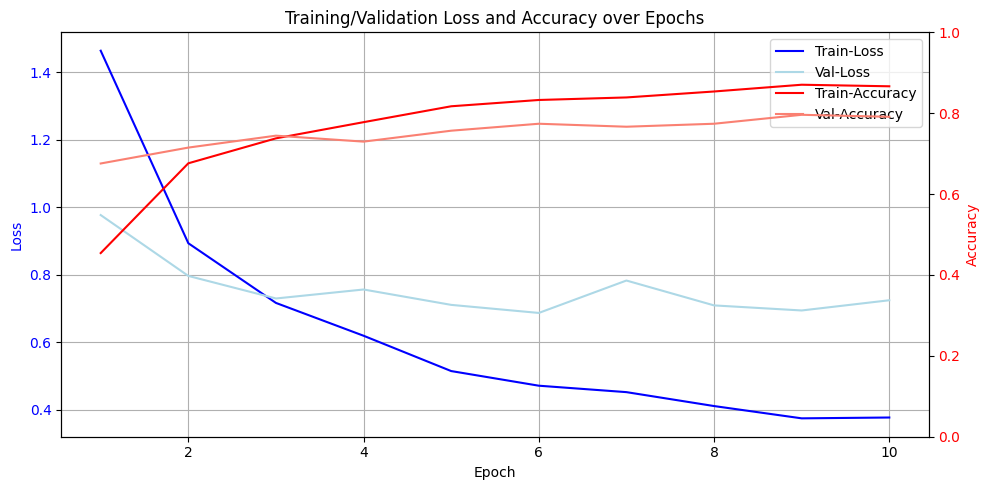

In [ ]:
# ## Trainingshistorie Plots

# Plot der Trainingshistorie (Loss und Accuracy mit zwei Y-Achsen)

import matplotlib.pyplot as plt

# Stellen Sie sicher, dass die Listen mit der Trainingshistorie verfügbar sind
# (epoch_train_loss_history, epoch_val_loss_history,
# epoch_train_acc_history, epoch_val_acc_history)

# Überprüfen Sie, ob Daten in den Listen vorhanden sind
if not epoch_train_loss_history or not epoch_val_loss_history or not epoch_train_acc_history or not epoch_val_acc_history:
    print("Es sind keine Trainingshistorie-Daten zum Plotten verfügbar.")
else:
    epochs = range(1, len(epoch_train_loss_history) + 1)

    # Initialisieren Sie die Figure und eine Achse
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Erstellen Sie eine zweite Achse, die sich die X-Achse mit der ersten Achse teilt
    ax2 = ax1.twinx()

    # Plots auf der ersten Y-Achse (Loss)
    ax1.plot(epochs, epoch_train_loss_history, label='Train-Loss', color='blue')
    ax1.plot(epochs, epoch_val_loss_history, label='Val-Loss', color='lightblue')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Plots auf der zweiten Y-Achse (Accuracy)
    ax2.plot(epochs, epoch_train_acc_history, label='Train-Accuracy', color='red')
    ax2.plot(epochs, epoch_val_acc_history, label='Val-Accuracy', color='salmon')
    ax2.set_ylabel("Accuracy", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 1) # Accuracy liegt zwischen 0 und 1

    # Titel für die gesamte Figure
    plt.title("Training/Validation Loss and Accuracy over Epochs")

    # Kombiniere Legenden von beiden Achsen
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # Layout anpassen
    plt.tight_layout()

    # Plot anzeigen
    plt.show()

In [ ]:
# Testloader
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=pin_memory_flag
)

errors = []
model.eval()
running_corrects = 0
nr_samples = 0
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels)
    nr_samples += images.shape[0]
    if preds != labels:
      errors.append({"image":images.to("cpu")[0], "y_hat":preds.to("cpu")[0].item(), "label":labels.to("cpu")[0].item()})
print()
print(f"Accuracy on Test dataset: {(running_corrects/nr_samples)*100:.3f} %")



100%|██████████| 99/99 [00:08<00:00, 12.23it/s]


Accuracy on Test dataset: 67.677 %



Beginne Berechnung der klassenspezifischen Accuracy auf Validierungsdaten für Barplot...


Validierungsdaten klassenweise testen (für Barplot): 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]



Klassenspezifische Accuracy auf den Validierungsdaten (für Barplot):
  Accuracy von 'basal cell carcinoma': 92.00% (69/75)
  Accuracy von 'dermatofibroma': 63.16% (12/19)
  Accuracy von 'melanoma': 79.31% (69/87)
  Accuracy von 'nevus': 73.24% (52/71)
  Accuracy von 'pigmented benign keratosis': 80.43% (74/92)
  Accuracy von 'squamous cell carcinoma': 52.78% (19/36)
  Accuracy von 'vascular lesion': 100.00% (27/27)


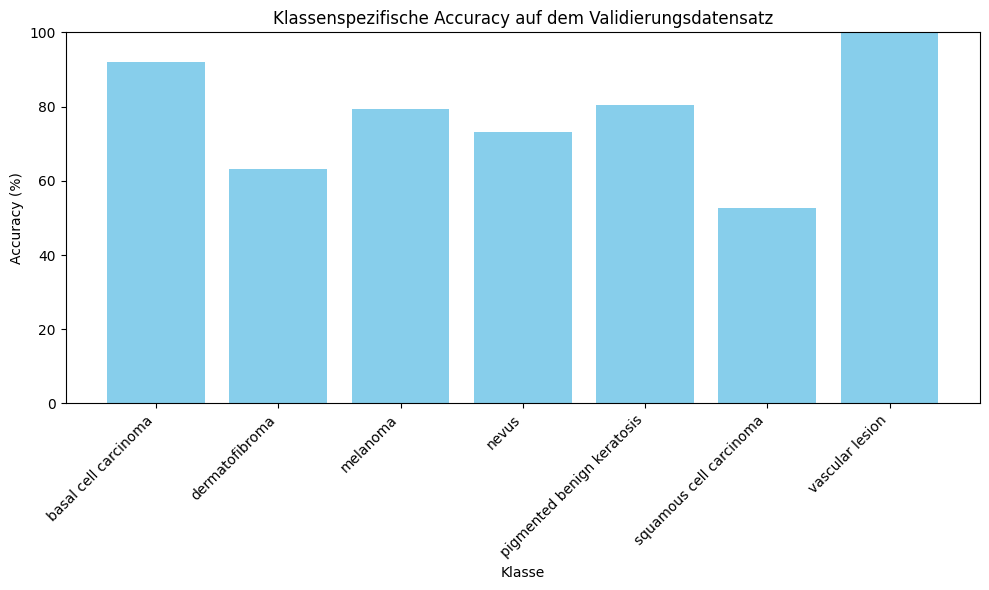

In [ ]:
# Teste die klassenspezifische Accuracy auf dem Validierungsdatensatz und visualisiere sie als Barplot

import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import torch # Stellen Sie sicher, dass torch importiert ist
import numpy as np # Stellen Sie sicher, dass numpy importiert ist


# Stellen Sie sicher, dass das Modell im Evaluationsmodus ist
model.eval()

# Listen zum Speichern der korrekten Vorhersagen und der Gesamtzahl der Samples pro Klasse
num_classes = len(val_dataset.classes) # Anzahl der Klassen aus dem Validierungsdatensatz
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

print("\nBeginne Berechnung der klassenspezifischen Accuracy auf Validierungsdaten für Barplot...")

# Deaktiviere Gradientenberechnung für den Testdurchlauf
with torch.no_grad():
    # Verwende den bereits definierten val_loader
    val_test_pbar = tqdm(val_loader, desc='Validierungsdaten klassenweise testen (für Barplot)')

    for images, labels in val_test_pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Berechnung der klassenspezifischen Accuracy für den aktuellen Batch
        c = (preds == labels).squeeze()

        if c.ndim == 0: # Fall für batch_size = 1
            c = c.unsqueeze(0)

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nKlassenspezifische Accuracy auf den Validierungsdaten (für Barplot):")

# Berechne die Accuracy pro Klasse
class_accuracy = {}
if hasattr(val_dataset, 'classes'):
    class_names = val_dataset.classes
else:
    class_names = [f"Klasse {i}" for i in range(num_classes)]


for i in range(num_classes):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        class_accuracy[class_names[i]] = accuracy
        print(f"  Accuracy von '{class_names[i]}': {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")
    else:
        class_accuracy[class_names[i]] = 0 # Setze Accuracy auf 0, wenn keine Daten vorhanden sind
        print(f"  Keine Validierungsdaten für '{class_names[i]}'")


# Erstelle den Barplot
classes = list(class_accuracy.keys())
accuracies = list(class_accuracy.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, accuracies, color='skyblue')
plt.xlabel("Klasse")
plt.ylabel("Accuracy (%)")
plt.title("Klassenspezifische Accuracy auf dem Validierungsdatensatz")
plt.ylim(0, 100) # Accuracy geht von 0 bis 100%
plt.xticks(rotation=45, ha='right') # Klassenlabels rotieren für bessere Lesbarkeit
plt.tight_layout() # Passt das Layout an, um Labels nicht zu überlappen
plt.show()

Label: 0, Prediction: 4


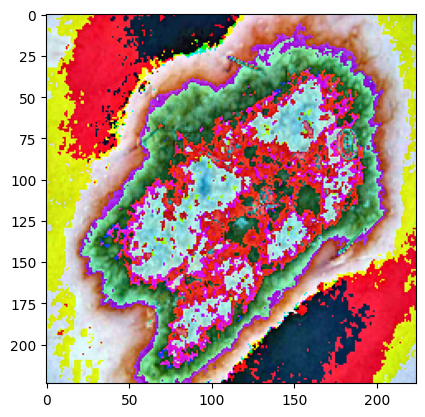

In [ ]:
# Plotting the error image
idx = 1
print(f"Label: {errors[idx]['label']}, Prediction: {errors[idx]['y_hat']}")
plt.imshow((errors[idx]['image'].permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.show()

In [ ]:
"""
# Modell laden mit freeze (nur letztes layer)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Identifizieren Sie den letzten Layer und seine Parameter
# EfficientNet hat eine 'classifier' Sequenz, der letzte Layer ist typischerweise der letzte in dieser Sequenz
num_ftrs = model.classifier[1].in_features
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(num_ftrs, num_classes)


# Frieren Sie alle Parameter ein, indem Sie requires_grad auf False setzen
for param in model.parameters():
    param.requires_grad = False

# Tauen Sie die Parameter des letzten Layers auf (classifier[1]), um sie zu trainieren
for param in model.classifier.parameters():
    param.requires_grad = True

model.to(device)

# Optimierung - Wichtig: Geben Sie nur die trainierbaren Parameter an den Optimierer
# Eine einfache Möglichkeit ist, alle Parameter zu filtern, deren requires_grad auf True gesetzt ist
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-2)

# --- Learning Rate Schedule initialisieren ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Listen zum Speichern von Loss, Accuracy und F1-Score pro Epoche
epoch_train_loss_history = []
epoch_train_acc_history = []
epoch_train_f1_history = []

epoch_val_loss_history = []
epoch_val_acc_history = []
epoch_val_f1_history = []

# Trainingsschleife (der Rest des Trainingscodes bleibt gleich)
num_epochs = 7
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    running_train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    nr_train_samples = 0
    train_labels_global = []
    train_preds_global = []

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics for training
        nr_train_samples += images.shape[0]
        running_train_loss += loss.item() * images.size(0)
        running_train_corrects += torch.sum(preds == labels)
        train_labels_global.extend(labels.tolist())
        train_preds_global.extend(preds.tolist())

        # Update progress bar
        cnt_train_acc = running_train_corrects / nr_train_samples
        cnt_train_loss = running_train_loss / nr_train_samples
        train_f1 = f1_score(train_labels_global, train_preds_global, average='micro')
        train_pbar.set_postfix(loss=f'{cnt_train_loss:.3f}', acc=f'{cnt_train_acc:.3f}', f1=f'{train_f1:.3f}')


    # Store training metrics
    epoch_train_loss_history.append(running_train_loss / nr_train_samples)
    epoch_train_acc_history.append((running_train_corrects / nr_train_samples).cpu().item())
    epoch_train_f1_history.append(train_f1)

    # --- Learning Rate Schedule Step (Epoch-basiert) ---
    # Optional: Aktuelle Lernrate ausgeben, um zu sehen, wie sie sich ändert
    print(f"Epoch {epoch+1} - Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")


    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    running_val_corrects = 0
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')
    nr_val_samples = 0
    val_labels_global = []
    val_preds_global = []

    with torch.no_grad(): # Disable gradient calculation during validation
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update metrics for validation
            nr_val_samples += images.shape[0]
            running_val_loss += loss.item() * images.size(0)
            running_val_corrects += torch.sum(preds == labels)
            val_labels_global.extend(labels.tolist())
            val_preds_global.extend(preds.tolist())

            # Update progress bar
            cnt_val_acc = running_val_corrects / nr_val_samples
            cnt_val_loss = running_val_loss / nr_val_samples
            val_f1 = f1_score(val_labels_global, val_preds_global, average='micro')
            val_pbar.set_postfix(loss=f'{cnt_val_loss:.3f}', acc=f'{cnt_val_acc:.3f}', f1=f'{val_f1:.3f}')

    # Store validation metrics BEFORE calling scheduler.step
    epoch_val_loss_history.append(running_val_loss / nr_val_samples)
    epoch_val_acc_history.append((running_val_corrects / nr_val_samples).cpu().item())
    epoch_val_f1_history.append(val_f1)

    # Now epoch_val_loss_history has at least one element
    scheduler.step(epoch_val_loss_history[-1])


    # Optional: Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {epoch_train_loss_history[-1]:.3f}, Train Acc: {epoch_train_acc_history[-1]:.3f}, Train F1: {epoch_train_f1_history[-1]:.3f} | Val Loss: {epoch_val_loss_history[-1]:.3f}, Val Acc: {epoch_val_acc_history[-1]:.3f}, Val F1: {epoch_val_f1_history[-1]:.3f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/7 [Train]: 100%|██████████| 105/105 [00:30<00:00,  3.48it/s, acc=0.155, f1=0.155, loss=2.171]


Epoch 1 - Learning Rate: 0.000100


Epoch 1/7 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s, acc=0.239, f1=0.239, loss=2.085]


Epoch 1 - Train Loss: 2.171, Train Acc: 0.155, Train F1: 0.155 | Val Loss: 2.085, Val Acc: 0.239, Val F1: 0.239


Epoch 2/7 [Train]: 100%|██████████| 105/105 [00:30<00:00,  3.48it/s, acc=0.239, f1=0.239, loss=2.085]


Epoch 2 - Learning Rate: 0.000100


Epoch 2/7 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.82it/s, acc=0.309, f1=0.309, loss=2.019]


Epoch 2 - Train Loss: 2.085, Train Acc: 0.239, Train F1: 0.239 | Val Loss: 2.019, Val Acc: 0.309, Val F1: 0.309


Epoch 3/7 [Train]: 100%|██████████| 105/105 [00:30<00:00,  3.49it/s, acc=0.305, f1=0.305, loss=2.014]


Epoch 3 - Learning Rate: 0.000100


Epoch 3/7 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.88it/s, acc=0.376, f1=0.376, loss=1.952]


Epoch 3 - Train Loss: 2.014, Train Acc: 0.305, Train F1: 0.305 | Val Loss: 1.952, Val Acc: 0.376, Val F1: 0.376


Epoch 4/7 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.60it/s, acc=0.322, f1=0.322, loss=1.971]


Epoch 4 - Learning Rate: 0.000100


Epoch 4/7 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s, acc=0.390, f1=0.390, loss=1.900]


Epoch 4 - Train Loss: 1.971, Train Acc: 0.322, Train F1: 0.322 | Val Loss: 1.900, Val Acc: 0.390, Val F1: 0.390


Epoch 5/7 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.50it/s, acc=0.356, f1=0.356, loss=1.920]


Epoch 5 - Learning Rate: 0.000100


Epoch 5/7 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.92it/s, acc=0.408, f1=0.408, loss=1.858]


Epoch 5 - Train Loss: 1.920, Train Acc: 0.356, Train F1: 0.356 | Val Loss: 1.858, Val Acc: 0.408, Val F1: 0.408


Epoch 6/7 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.52it/s, acc=0.379, f1=0.379, loss=1.869]


Epoch 6 - Learning Rate: 0.000100


Epoch 6/7 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.87it/s, acc=0.410, f1=0.410, loss=1.817]


Epoch 6 - Train Loss: 1.869, Train Acc: 0.379, Train F1: 0.379 | Val Loss: 1.817, Val Acc: 0.410, Val F1: 0.410


Epoch 7/7 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.56it/s, acc=0.395, f1=0.395, loss=1.831]


Epoch 7 - Learning Rate: 0.000100


Epoch 7/7 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.90it/s, acc=0.412, f1=0.412, loss=1.773]

Epoch 7 - Train Loss: 1.831, Train Acc: 0.395, Train F1: 0.395 | Val Loss: 1.773, Val Acc: 0.412, Val F1: 0.412


In [ ]:
"""
# Modell laden (mit freeze ind vorletztes layer)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Identifizieren Sie den letzten Layer und seine Parameter
num_ftrs = model.classifier[1].in_features
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(num_ftrs, num_classes)


# Frieren Sie zunächst alle Parameter ein
for param in model.parameters():
    param.requires_grad = False

# Tauen Sie den Classifier (die letzten Layer) auf
for param in model.classifier.parameters():
    param.requires_grad = True

# Identifizieren und tauen Sie die letzten Blöcke des Feature Extractors auf
# Die genauen Namen der Blöcke können je nach EfficientNet-Variante variieren.
# Für EfficientNet-B0 sind die Feature-Stufen in _blocks enthalten.
# Wir tauen hier beispielhaft die letzten 2-3 Blöcke auf.
# Sie können die Struktur des Modells mit print(model) untersuchen, um die Blocknamen zu finden.
# Achtung: Die Indizierung kann variieren, dies ist ein Beispiel für B0
num_blocks_to_unfreeze = 3 # Anzahl der letzten Blöcke im Feature Extractor, die aufgetaut werden sollen
total_blocks = len(model.features) # Anzahl der Blöcke im Feature Extractor

# Tauen Sie die letzten num_blocks_to_unfreeze Blöcke auf
for i in range(total_blocks - num_blocks_to_unfreeze, total_blocks):
    for param in model.features[i].parameters():
        param.requires_grad = True

model.to(device)

# Optimierung - Wichtig: Geben Sie nur die trainierbaren Parameter an den Optimierer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005, weight_decay=1e-2) # Oft wird eine kleinere Lernrate verwendet

# --- Learning Rate Schedule initialisieren ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Listen zum Speichern von Loss, Accuracy und F1-Score pro Epoche
epoch_train_loss_history = []
epoch_train_acc_history = []
epoch_train_f1_history = []

epoch_val_loss_history = []
epoch_val_acc_history = []
epoch_val_f1_history = []


# Trainingsschleife (wie zuvor)
num_epochs = 20
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    running_train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    nr_train_samples = 0
    train_labels_global = []
    train_preds_global = []

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics for training
        nr_train_samples += images.shape[0]
        running_train_loss += loss.item() * images.size(0)
        running_train_corrects += torch.sum(preds == labels)
        train_labels_global.extend(labels.tolist())
        train_preds_global.extend(preds.tolist())

        # Update progress bar
        cnt_train_acc = running_train_corrects / nr_train_samples
        cnt_train_loss = running_train_loss / nr_train_samples
        train_f1 = f1_score(train_labels_global, train_preds_global, average='micro')
        train_pbar.set_postfix(loss=f'{cnt_train_loss:.3f}', acc=f'{cnt_train_acc:.3f}', f1=f'{train_f1:.3f}')


    # Store training metrics
    epoch_train_loss_history.append(running_train_loss / nr_train_samples)
    epoch_train_acc_history.append((running_train_corrects / nr_train_samples).cpu().item())
    epoch_train_f1_history.append(train_f1)

    # --- Learning Rate Schedule Step (Epoch-basiert) ---
    print(f"Epoch {epoch+1} - Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")


    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    running_val_corrects = 0
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')
    nr_val_samples = 0
    val_labels_global = []
    val_preds_global = []

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            nr_val_samples += images.shape[0]
            running_val_loss += loss.item() * images.size(0)
            running_val_corrects += torch.sum(preds == labels)
            val_labels_global.extend(labels.tolist())
            val_preds_global.extend(preds.tolist())

            cnt_val_acc = running_val_corrects / nr_val_samples
            cnt_val_loss = running_val_loss / nr_val_samples
            val_f1 = f1_score(val_labels_global, val_preds_global, average='micro')
            val_pbar.set_postfix(loss=f'{cnt_val_loss:.3f}', acc=f'{cnt_val_acc:.3f}', f1=f'{val_f1:.3f}')


    epoch_val_loss_history.append(running_val_loss / nr_val_samples)
    epoch_val_acc_history.append((running_val_corrects / nr_val_samples).cpu().item())
    epoch_val_f1_history.append(val_f1)

    scheduler.step(epoch_val_loss_history[-1])

    print(f"Epoch {epoch+1} - Train Loss: {epoch_train_loss_history[-1]:.3f}, Train Acc: {epoch_train_acc_history[-1]:.3f}, Train F1: {epoch_train_f1_history[-1]:.3f} | Val Loss: {epoch_val_loss_history[-1]:.3f}, Val Acc: {epoch_val_acc_history[-1]:.3f}, Val F1: {epoch_val_f1_history[-1]:.3f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20 [Train]: 100%|██████████| 105/105 [00:30<00:00,  3.48it/s, acc=0.207, f1=0.207, loss=2.124]


Epoch 1 - Learning Rate: 0.000050


Epoch 1/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s, acc=0.338, f1=0.338, loss=1.985]


Epoch 1 - Train Loss: 2.124, Train Acc: 0.207, Train F1: 0.207 | Val Loss: 1.985, Val Acc: 0.338, Val F1: 0.338


Epoch 2/20 [Train]: 100%|██████████| 105/105 [00:31<00:00,  3.38it/s, acc=0.369, f1=0.369, loss=1.896]


Epoch 2 - Learning Rate: 0.000050


Epoch 2/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.78it/s, acc=0.446, f1=0.446, loss=1.732]


Epoch 2 - Train Loss: 1.896, Train Acc: 0.369, Train F1: 0.369 | Val Loss: 1.732, Val Acc: 0.446, Val F1: 0.446


Epoch 3/20 [Train]: 100%|██████████| 105/105 [00:31<00:00,  3.34it/s, acc=0.439, f1=0.439, loss=1.666]


Epoch 3 - Learning Rate: 0.000050


Epoch 3/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s, acc=0.502, f1=0.502, loss=1.501]


Epoch 3 - Train Loss: 1.666, Train Acc: 0.439, Train F1: 0.439 | Val Loss: 1.501, Val Acc: 0.502, Val F1: 0.502


Epoch 4/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.51it/s, acc=0.494, f1=0.494, loss=1.476]


Epoch 4 - Learning Rate: 0.000050


Epoch 4/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s, acc=0.507, f1=0.507, loss=1.385]


Epoch 4 - Train Loss: 1.476, Train Acc: 0.494, Train F1: 0.494 | Val Loss: 1.385, Val Acc: 0.507, Val F1: 0.507


Epoch 5/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.56it/s, acc=0.502, f1=0.502, loss=1.397]


Epoch 5 - Learning Rate: 0.000050


Epoch 5/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s, acc=0.559, f1=0.559, loss=1.245]


Epoch 5 - Train Loss: 1.397, Train Acc: 0.502, Train F1: 0.502 | Val Loss: 1.245, Val Acc: 0.559, Val F1: 0.559


Epoch 6/20 [Train]: 100%|██████████| 105/105 [00:30<00:00,  3.42it/s, acc=0.548, f1=0.548, loss=1.279]


Epoch 6 - Learning Rate: 0.000050


Epoch 6/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s, acc=0.554, f1=0.554, loss=1.161]


Epoch 6 - Train Loss: 1.279, Train Acc: 0.548, Train F1: 0.548 | Val Loss: 1.161, Val Acc: 0.554, Val F1: 0.554


Epoch 7/20 [Train]: 100%|██████████| 105/105 [00:28<00:00,  3.65it/s, acc=0.574, f1=0.574, loss=1.209]


Epoch 7 - Learning Rate: 0.000050


Epoch 7/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.80it/s, acc=0.599, f1=0.599, loss=1.122]


Epoch 7 - Train Loss: 1.209, Train Acc: 0.574, Train F1: 0.574 | Val Loss: 1.122, Val Acc: 0.599, Val F1: 0.599


Epoch 8/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.57it/s, acc=0.572, f1=0.572, loss=1.166]


Epoch 8 - Learning Rate: 0.000050


Epoch 8/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s, acc=0.610, f1=0.610, loss=1.079]


Epoch 8 - Train Loss: 1.166, Train Acc: 0.572, Train F1: 0.572 | Val Loss: 1.079, Val Acc: 0.610, Val F1: 0.610


Epoch 9/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.52it/s, acc=0.600, f1=0.600, loss=1.132]


Epoch 9 - Learning Rate: 0.000050


Epoch 9/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s, acc=0.588, f1=0.588, loss=1.089]


Epoch 9 - Train Loss: 1.132, Train Acc: 0.600, Train F1: 0.600 | Val Loss: 1.089, Val Acc: 0.588, Val F1: 0.588


Epoch 10/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.61it/s, acc=0.598, f1=0.598, loss=1.095]


Epoch 10 - Learning Rate: 0.000050


Epoch 10/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.82it/s, acc=0.601, f1=0.601, loss=1.044]


Epoch 10 - Train Loss: 1.095, Train Acc: 0.598, Train F1: 0.598 | Val Loss: 1.044, Val Acc: 0.601, Val F1: 0.601


Epoch 11/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.60it/s, acc=0.637, f1=0.637, loss=1.037]


Epoch 11 - Learning Rate: 0.000050


Epoch 11/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s, acc=0.624, f1=0.624, loss=0.968]


Epoch 11 - Train Loss: 1.037, Train Acc: 0.637, Train F1: 0.637 | Val Loss: 0.968, Val Acc: 0.624, Val F1: 0.624


Epoch 12/20 [Train]: 100%|██████████| 105/105 [00:30<00:00,  3.45it/s, acc=0.638, f1=0.638, loss=1.023]


Epoch 12 - Learning Rate: 0.000050


Epoch 12/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s, acc=0.581, f1=0.581, loss=1.043]


Epoch 12 - Train Loss: 1.023, Train Acc: 0.638, Train F1: 0.638 | Val Loss: 1.043, Val Acc: 0.581, Val F1: 0.581


Epoch 13/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.57it/s, acc=0.642, f1=0.642, loss=0.994]


Epoch 13 - Learning Rate: 0.000050


Epoch 13/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s, acc=0.626, f1=0.626, loss=0.967]


Epoch 13 - Train Loss: 0.994, Train Acc: 0.642, Train F1: 0.642 | Val Loss: 0.967, Val Acc: 0.626, Val F1: 0.626


Epoch 14/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.52it/s, acc=0.644, f1=0.644, loss=0.996]


Epoch 14 - Learning Rate: 0.000050


Epoch 14/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s, acc=0.637, f1=0.637, loss=0.959]


Epoch 14 - Train Loss: 0.996, Train Acc: 0.644, Train F1: 0.644 | Val Loss: 0.959, Val Acc: 0.637, Val F1: 0.637


Epoch 15/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.54it/s, acc=0.660, f1=0.660, loss=0.944]


Epoch 15 - Learning Rate: 0.000050


Epoch 15/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s, acc=0.640, f1=0.640, loss=0.971]


Epoch 15 - Train Loss: 0.944, Train Acc: 0.660, Train F1: 0.660 | Val Loss: 0.971, Val Acc: 0.640, Val F1: 0.640


Epoch 16/20 [Train]: 100%|██████████| 105/105 [00:30<00:00,  3.40it/s, acc=0.674, f1=0.674, loss=0.915]


Epoch 16 - Learning Rate: 0.000050


Epoch 16/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s, acc=0.622, f1=0.622, loss=0.987]


Epoch 16 - Train Loss: 0.915, Train Acc: 0.674, Train F1: 0.674 | Val Loss: 0.987, Val Acc: 0.622, Val F1: 0.622


Epoch 17/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.56it/s, acc=0.683, f1=0.683, loss=0.888]


Epoch 17 - Learning Rate: 0.000050


Epoch 17/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s, acc=0.633, f1=0.633, loss=0.992]


Epoch 17 - Train Loss: 0.888, Train Acc: 0.683, Train F1: 0.683 | Val Loss: 0.992, Val Acc: 0.633, Val F1: 0.633


Epoch 18/20 [Train]: 100%|██████████| 105/105 [00:31<00:00,  3.36it/s, acc=0.675, f1=0.675, loss=0.915]


Epoch 18 - Learning Rate: 0.000050


Epoch 18/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.82it/s, acc=0.631, f1=0.631, loss=0.989]


Epoch 18 - Train Loss: 0.915, Train Acc: 0.675, Train F1: 0.675 | Val Loss: 0.989, Val Acc: 0.631, Val F1: 0.631


Epoch 19/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.55it/s, acc=0.685, f1=0.685, loss=0.873]


Epoch 19 - Learning Rate: 0.000005


Epoch 19/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.83it/s, acc=0.664, f1=0.664, loss=0.982]


Epoch 19 - Train Loss: 0.873, Train Acc: 0.685, Train F1: 0.685 | Val Loss: 0.982, Val Acc: 0.664, Val F1: 0.664


Epoch 20/20 [Train]: 100%|██████████| 105/105 [00:29<00:00,  3.54it/s, acc=0.700, f1=0.700, loss=0.831]


Epoch 20 - Learning Rate: 0.000005


Epoch 20/20 [Valid]: 100%|██████████| 14/14 [00:03<00:00,  3.82it/s, acc=0.655, f1=0.655, loss=0.949]

Epoch 20 - Train Loss: 0.831, Train Acc: 0.700, Train F1: 0.700 | Val Loss: 0.949, Val Acc: 0.655, Val F1: 0.655
